# Prerequisites
The fastest way to get started is to load my docker image, which comes with all the dependencies that you need.
```
docker pull jamestjw/face-rec
docker run -p 9000:9000 -p 8000:8000 -t -i jamestjw/face-rec /bin/bash
cd /root/openface
```

In [79]:
from PIL import Image
import os
import numpy as np
import pandas as pd
from scipy.spatial import KDTree

import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
# export PATH=$PATH:/root/openface

In [81]:
from openface import *

Pretrained network that generates embeddings for our images.

Copy images to `images` directory.

In [82]:
# !mkdir training-images
# !cp /host/Users/james/Documents/nbs/Portrait\ Scraping/images/* images/ -r

# Align images
First, this process identifies the location of a human face and crops it, next we have to align the images so that all images have their eyes, noses, mouths etc in the center. This is far from a perfect process but we do the best that we can.

Hyperparameters.



In [83]:
#Skip image with more than one face
skipMulti = True
size=96
landmarkIndices = AlignDlib.OUTER_EYES_AND_NOSE

Define model paths and initialise alignment model and embedding model.

In [84]:
fileDir = '/root/openface'
modelDir = os.path.join(fileDir, 'models')
dlibModelDir = os.path.join(modelDir, 'dlib')
face_predictor_path = os.path.join(dlibModelDir, "shape_predictor_68_face_landmarks.dat")
model_path = os.path.join(modelDir, 'openface', 'nn4.small2.v1.t7')

#alignment model
align = AlignDlib(face_predictor_path)
#embedding model
model = TorchNeuralNet(model=model_path)

## Example

In [21]:
tom = './images/tom holland/7.tumblr_pooq857m1a1w3lpd1_540.jpg'
tom_image = data.Image(cls='tom',name='random_tom',path=tom)
imgObject = tom_image

Original image.

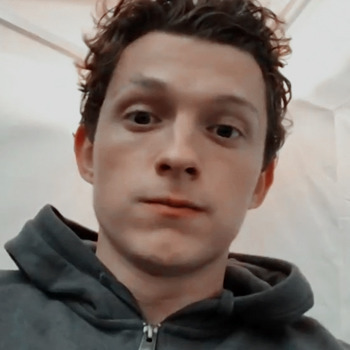

In [22]:
rgb = imgObject.getRGB()
Image.fromarray(rgb)

Aligned image.

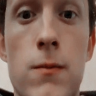

In [23]:
outRgb = align.align(size, rgb, landmarkIndices=landmarkIndices, skipMulti=skipMulti)
Image.fromarray(outRgb)

# Obtain the embeddings

We get the 128-dimensional vector that corresponds to Tom Holland!

In [24]:
out128 = model.forward(outRgb)
out128.shape

(128,)

# Doing the same thing en masse.
We can align all images within a directory with this script.

In [27]:
!{fileDir}/util/align-dlib.py ./images/ align outerEyesAndNose ./aligned-images/ --size 96

=== ./images/dwayne johnson/1.Frances-and-The-Rock.jpg ===
=== ./images/benedict cumberbatch/5.benedict-cumberbatch-sherlock-season-4.png ===
=== ./images/robert downey jr/7.robert_downey_jr__by_ginchilla194_d9unp1d-350t.jpg ===
=== ./images/tom hiddleston/7.tumblr_mapo49WIUH1rc6wkbo3_400.png ===
=== ./images/tom holland/8.dd09631b27c8508ed700797c97849bd9.jpg ===
=== ./images/tom hiddleston/1.111320-23.jpg ===
=== ./images/robert downey jr/8.tumblr_m9fmfcvJar1r9f8c9o5_400.jpg ===
=== ./images/tom holland/7.tumblr_pooq857m1a1w3lpd1_540.jpg ===
=== ./images/dwayne johnson/5.Life-Size-Superhero-Statue-Muscular-Mannequin-Dwayne.jpg ===
=== ./images/dwayne johnson/10.51Ro86IHmnL._SL500_AC_SS350_.jpg ===
=== ./images/dwayne johnson/7.20190113_233416-350x350.jpg ===
=== ./images/robert downey jr/2.robert_downey_jr__from_chaplin__1992__by_vickeey08_dc0kwvu-350t.jpg ===
=== ./images/jason statham/7.41kqaolEr8L._SL500_AC_SS350_.jpg ===
=== ./images/robert downey jr/5.rdj_portrait_drawing_by_draw

Same result.

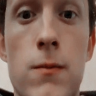

In [28]:
Image.open('./aligned-images/tom holland/7.tumblr_pooq857m1a1w3lpd1_540.png')

We can then get embeddings for all those images via another script.

In [29]:
!{fileDir}/batch-represent/main.lua -outDir ./generated-embeddings/ -data ./aligned-images/

{
  data : "./aligned-images/"
  imgDim : 96
  model : "/root/openface/models/openface/nn4.small2.v1.t7"
  device : 1
  outDir : "./generated-embeddings/"
  cache : false
  cuda : false
  batchSize : 50
}
./aligned-images/	
cache lotation: 	/host/Users/james/Documents/nbs/Portrait Scraping/aligned-images/cache.t7	
Creating metadata for cache.	
{
  sampleSize : 
    {
      1 : 3
      2 : 96
      3 : 96
    }
  split : 0
  verbose : true
  paths : 
    {
      1 : "./aligned-images/"
    }
  samplingMode : "balanced"
  loadSize : 
    {
      1 : 3
      2 : 96
      3 : 96
    }
}
running "find" on each class directory, and concatenate all those filenames into a single file containing all image paths for a given class	
now combine all the files to a single large file	
load the large concatenated list of sample paths to self.imagePath	
45 samples found.	......................]                              ETA: 0ms | Step: 0m 0/45 
Updating classList and imageClass appropriately	
 [===

We now have all our embeddings and vectors in a nice format.

In [5]:
embeddings = np.genfromtxt('../Portrait Scraping/generated-embeddings/reps.csv', delimiter=',')
labels = pd.read_csv('../Portrait Scraping/generated-embeddings/labels.csv',names=['class','path'])
print(embeddings.shape)
print(labels.shape)
labels.head()

(45, 128)
(45, 2)


,class,path
0,1,./aligned-images/robert downey jr/2.robert_dow...
1,1,./aligned-images/robert downey jr/6.41bsBEFNYP...
2,1,./aligned-images/robert downey jr/4.41fgqxer4S...
3,1,./aligned-images/robert downey jr/5.rdj_portra...
4,1,./aligned-images/robert downey jr/9.tumblr_m9f...


# Inference
Let's try to see if things really work, given an image of one person, we want to find more images like it.

In [8]:
labels['person'] = labels['path'].apply(lambda x: x.split('/')[2])
labels['original_path'] = labels['path'].apply(lambda x: '/'.join(x.split('/')[2:]))
labels['original_path'] = labels['original_path'].apply(lambda x: x[:-3]+'jpg')

In [23]:
idx = 18
cls = labels['person'][idx]
path = labels['original_path'][idx]

print('Looking at image {}, Class: {}, Path: {}'.format(idx,cls,path))

Looking at image 18, Class: tom hiddleston, Path: tom hiddleston/1.111320-23.jpg


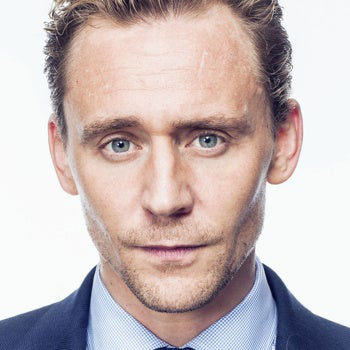

In [24]:
Image.open('../Portrait Scraping/images/'+labels['original_path'][idx])

In [75]:
# %%timeit
tree = KDTree(embeddings)
tom_vec = embeddings[idx]
_,idxs = tree.query(tom_vec,k=10)

In [76]:
idxs

array([18, 24, 22, 25, 20, 26, 19, 23, 40,  0])

In [22]:
#We ignore the first image here, the most similar image will necessarily be itself
found_df = labels.iloc[idxs]
found_df.head()

,class,path,person,original_path
44,6,./aligned-images/jason statham/4.81uap2pdCYL._...,jason statham,jason statham/4.81uap2pdCYL._AC_SS350_.jpg
41,6,./aligned-images/jason statham/2.41DxZfaQPRL._...,jason statham,jason statham/2.41DxZfaQPRL._SL500_AC_SS350_.jpg
19,3,./aligned-images/tom hiddleston/3.516AzVaa7NL....,tom hiddleston,tom hiddleston/3.516AzVaa7NL._SL500_AC_SS350_.jpg
12,2,./aligned-images/dwayne johnson/7.20190113_233...,dwayne johnson,dwayne johnson/7.20190113_233416-350x350.jpg


We expect all images of Tom to be in the top 10 at least, let's see which image of Tom we didn't quite catch here.

In [10]:
found_set = set(found_df.head(10)['original_path'])
all_toms = set(labels[labels['person']=='tom hiddleston']['original_path'])

not_found = [tom for tom in all_toms if tom not in found_set]
not_found

['tom hiddleston/2.taylor-swift-tom-hiddleston-love-bubble.jpg']

Alright perhaps B&W photos don't work very well.

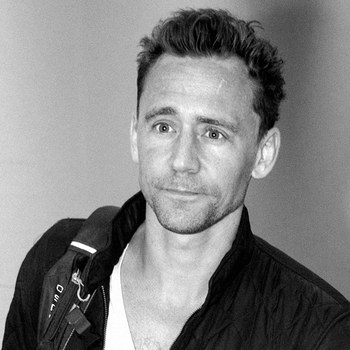

In [12]:
Image.open('../Portrait Scraping/images/'+not_found[0])

## One more example.

Looking at image 41, Class: jason statham, Path: jason statham/2.41DxZfaQPRL._SL500_AC_SS350_.jpg


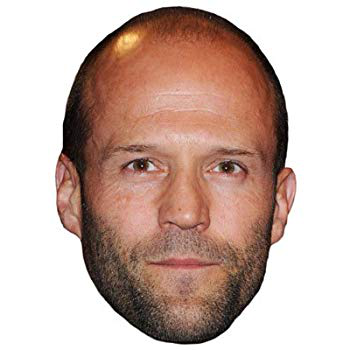

In [9]:
idx = 41
cls = labels['person'][idx]
path = labels['original_path'][idx]

print('Looking at image {}, Class: {}, Path: {}'.format(idx,cls,path))
Image.open('../Portrait Scraping/images/'+labels['original_path'][idx])

In [10]:
tree = KDTree(embeddings)
jason_vec = embeddings[idx]
_,idxs = tree.query(jason_vec,k=10)

#We ignore the first image here, the most similar image will necessarily be itself
found_df = labels.iloc[idxs]
found_df.head()
idxs

array([41, 44, 42, 21, 17, 16, 12, 14, 36, 40])

In [11]:
# %%timeit
A = jason_vec[None]
B = embeddings

dots = np.dot(A,B.T)
l2norms = np.sqrt(((A**2).sum(1)[:,None])*((B**2).sum(1)))
cosine_similarity = dots/l2norms

idxs = np.argsort(cosine_similarity)[0]
idxs[:-4:-1]

array([41, 44, 42])

In [12]:
cosine_similarity[0][idxs[:-4:-1]]

array([1.        , 0.62447857, 0.5494207 ])

In [57]:
z

In [91]:
get_similarity(jason_vec[None],embeddings,1)

(array([0.]), array([41]))

In [97]:
np.sum(A[0]**2)

0.9999999346393793

In [15]:
found_set = set(found_df.head(5)['original_path'])
all_jasons = set(labels[labels['person']=='jason statham']['original_path'])

not_found = [jason for jason in all_jasons if jason not in found_set]
not_found

['jason statham/3.jason_statham_by_stef43_d727zh2-350t.jpg',
 'jason statham/7.41kqaolEr8L._SL500_AC_SS350_.jpg']

In [37]:
jason_vec.shape

(128,)

In [38]:
embeddings.shape

(45, 128)

Once again, we find that B&W images don't work well.

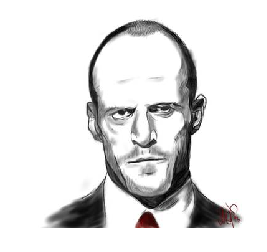

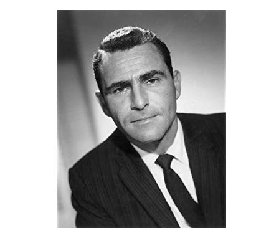

In [16]:
for nf in not_found:
    plt.figure()
    plt.imshow(Image.open('../Portrait Scraping/images/'+nf))
    plt.axis('off');

# Setting a Threshold
Although we are able to find images that most closely resemble the one we give the model, we still need a threshold of sorts to be absolutely certain that the image really matches something we have in our collection.

In order to tackle this problem, let's calculate the Euclidean distance between positive matches so that we can get a feel of what that <em>margin</em> should be. We only take into account the top 3 matches, and calculate the distances if there is a positive match.

In [19]:
names = labels['person']
positive_list = []
for name,vector in zip(names,embeddings):
    _,idxs = tree.query(vector,k=4)
    positives = [i for n,i in zip(map(names.__getitem__, idxs[:]),idxs[:]) if n == name]
    positive_list.append((vector,embeddings[positives]))

In [20]:
import scipy.spatial.distance

In [105]:
distances = [scipy.spatial.distance.pdist(p[1]) for p in positive_list]

0.9210277973000384


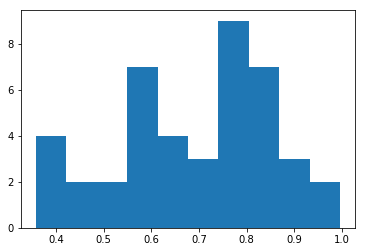

In [167]:
#Top 1 match distances
flattened_distances_1 = [d for sublist in distances for d in sublist[:1]]
threshold_1 = np.percentile(flattened_distances_1,95)
print(threshold_1)
plt.hist(flattened_distances_1);

0.9369400323882489


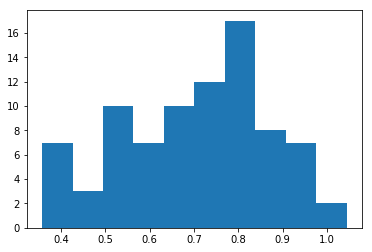

In [151]:
#Top 2 match distances
flattened_distances_2 = [d for sublist in distances for d in sublist[:2]]
plt.hist(flattened_distances_2);
threshold_2 = np.percentile(flattened_distances_2,95)
print(threshold_2)

In [22]:
positive_list[0][1]

array([[ 0.01362651,  0.06177789,  0.0840632 ,  0.10309086, -0.15113749,
         0.0683279 , -0.0605473 , -0.10232587,  0.0544362 , -0.11852449,
         0.13385056, -0.06563925,  0.05724676,  0.08333823,  0.01181905,
        -0.11276155,  0.03470423,  0.0874389 ,  0.03519587,  0.0002827 ,
         0.14854397,  0.02781219, -0.04243425,  0.21966523,  0.01686424,
        -0.03276137, -0.0575195 , -0.08803275,  0.07753308,  0.15397198,
         0.08600793, -0.04427554,  0.07272416, -0.03048066,  0.12384967,
         0.07937165, -0.00882205,  0.09578264, -0.08706646, -0.06712117,
        -0.08558491,  0.03458776, -0.12350296,  0.11537965, -0.02718137,
        -0.06604026,  0.0880883 , -0.01924162, -0.04895252, -0.09452443,
         0.011061  ,  0.09131809,  0.15221725, -0.00120964,  0.08748689,
         0.093119  , -0.03508234,  0.05544149,  0.08188311, -0.20223163,
        -0.09201939, -0.0121142 ,  0.08671897, -0.03492393, -0.00055171,
         0.00862845,  0.1908205 , -0.15634628, -0.0

Might make sense to set the threshold to `threshold_1` for now. 

In [23]:
for p in positive_list:
    print(p[1].shape)

(1, 128)
(2, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(3, 128)
(4, 128)
(4, 128)
(4, 128)
(3, 128)
(4, 128)
(3, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(3, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(4, 128)
(2, 128)
(3, 128)
(3, 128)
(1, 128)
(2, 128)


## Adversarial Attack
Let's see what kind of results will we get for a face that we do not have in our database.

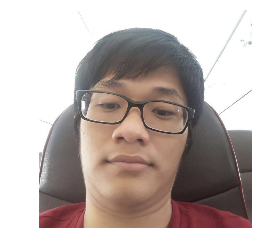

In [132]:
wong = data.Image(cls='new',name='new_image',path='wong.png')
rgb = wong.getRGB()
outRgb = align.align(size, rgb, landmarkIndices=landmarkIndices, skipMulti=skipMulti)
out128 = model.forward(outRgb)
plt.imshow(Image.fromarray(rgb))
plt.axis('off');

Seems to be pretty safe, our threshold will have prevented a false positive.

In [138]:
np.sqrt(np.sum((out128 - embeddings)**2,-1))

array([1.32046643, 1.40348584, 1.45024605, 1.26542979, 1.53640624,
       1.28979187, 1.14177773, 1.35786997, 1.30568982, 1.30930967,
       1.34110515, 1.17774883, 1.36853803, 1.2853766 , 1.01963116,
       1.31765599, 1.23416048, 1.14191546, 1.41484099, 1.40375386,
       1.44598132, 1.3375781 , 1.4115376 , 1.33422584, 1.40456506,
       1.39447071, 1.4161199 , 1.46838937, 1.4332563 , 1.42084328,
       1.48523632, 1.39976788, 1.43931472, 1.32235757, 1.36915736,
       1.05130145, 1.32728189, 1.11219772, 1.24183662, 1.2275629 ,
       1.42757207, 1.43274824, 1.55894341, 1.57837003, 1.44760153])

# Cosine Distance

In [93]:
def get_similarity(A,B,k=1):
    dots = np.dot(A,B.T)
    l2norms = np.sqrt(((A**2).sum(1)[:,None])*((B**2).sum(1)))
    cosine_similarity = 1 - dots/l2norms
    idxs = np.argsort(cosine_similarity)[0]
    return cosine_similarity[0][idxs[:k]], idxs[:k]

In [73]:
names = labels['person']
all_d = []
for count,(name,vector) in enumerate(zip(names,embeddings)):
    dists,idxs = get_similarity(vector[None],embeddings,4)
    distances = [d for n,i,d in zip(map(names.__getitem__, idxs[:]),idxs[:], dists) if(n == name and i != count)]
    all_d.append(distances)

0.38084561637879477


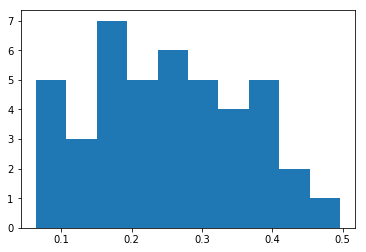

In [90]:
#Top 1 match distances
flattened_distances_1 = [d for sublist in all_d for d in sublist[:1]]
threshold_1 = np.percentile(flattened_distances_1,90)
print(threshold_1)
plt.hist(flattened_distances_1);

In [64]:
get_similarity(vector[None],embeddings,10)

(array([0.        , 0.37552143, 0.38142868, 0.38145588, 0.38217666,
        0.39152371, 0.3935554 , 0.41886562, 0.45769449, 0.47845538]),
 array([44, 41, 19, 12, 42, 40, 22, 26, 24, 25]))

## Recurring User
Suppose that a user that has registered with us has returned, can we identify him?

In [75]:
##Helper function to get embeddings
def get_embeddings(path, cls='new', name='new_image',plot=False):
    '''
    Get embeddings for an images.
    '''
    img = data.Image(cls='new',name='new_image',path=path)
    rgb = img.getRGB()
    outRgb = align.align(size, rgb, landmarkIndices=landmarkIndices, skipMulti=skipMulti)
    out128 = model.forward(outRgb) 
    if plot:
        plt.imshow(outRgb)
    return out128

In [35]:
embeddings.shape

(45, 128)

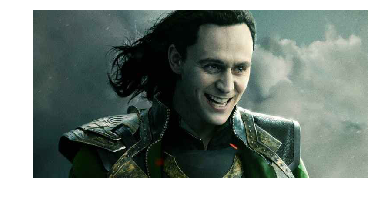

In [77]:
plt.imshow(Image.open('../Portrait Scraping/loki.jpg')); plt.axis('off');

In [24]:
vector.shape

(128,)

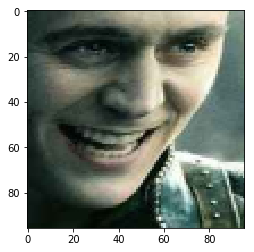

In [85]:
loki_vec = get_embeddings('../Portrait Scraping/loki.jpg',plot=True)

In [168]:
dist,idxs = tree.query(loki_vec,k=3)
print([names[i] for i in idxs])
print(dist)

['tom hiddleston', 'tom hiddleston', 'jason statham']
[0.73658889 0.88741541 0.93105334]


The false positive of Jason Statham would have been filtered out by our threshold, but it would have been close. There are a few things that we can do to improve this process:
1. Increase the size of crops so that we can see other stuff like hair, this may or may not be a good option though, since the presence of hair may be good when people have consistent hairstyles, but this opens the possibility of people fooling our model through wigs and whatnot.
2. Find a better threshold by running more images through our model and handpicking a more appropriate threshold.